## FFT and Wavelet Applications on a Sample of Traffic Data

### Purpose & Motivation
This notebook attempts to show an application of a fourier transform and a wavelet transform on traffic data, specifically the variable of flow.  Additionally, the team was generally interested in the exposure and educational process of better understanding Fourier Transforms and Wavelets.

### Direction from Advisor
During the last collaboration with Dr Freund we attempted to show that the wiggles propogated down a highway.  The method was slightly complex and described as a "poor man's fourier transform".  We were advised to research wavelets to see if they could provide a simpler and more elegant method for demonstrating wiggle propogation.
 

### Tasks/Questions to Answer
#### Questions to Answer
- By applying a FFT, are there any insights to be gained from traffic data?
- Can we apply a wavelet to demonstrate wiggle propogation?

#### Tasks
- Apply FFT to traffic flow data.
- Apply wavelets to traffic flow data.

### Results
##### FFT
The decision to do PCA on a day's worth of data was well founded.  We believe that since the frequency with the highest magnitude is 24 hours, this makes the PCA decision valid.  
##### Wavelets
The wavelets show some interesting results.  The short wavelet scale seems to show very similar results to our wiggle extraction technique (calculating a smoothed mean and differencing it with the original signal). The larger scale wavelets seem to magnify the overall signal in the data. 

### Conclusions
We feel that we dont fully understand how we were supposed to apply the wavelet to the data or how this can help with wiggle propogation.  

Unsure about next steps

### Imports and data prep

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.fftpack
import pandas as pd
import numpy as np
from scipy import signal

In [2]:
df = pd.read_csv('../data/I15S_data.csv')

In [3]:
idx1 = df['Station'] == 1108148 #filter to one station
df = df.ix[idx1,:]

### Plot Flow for station 1108148 over entire year of 2015

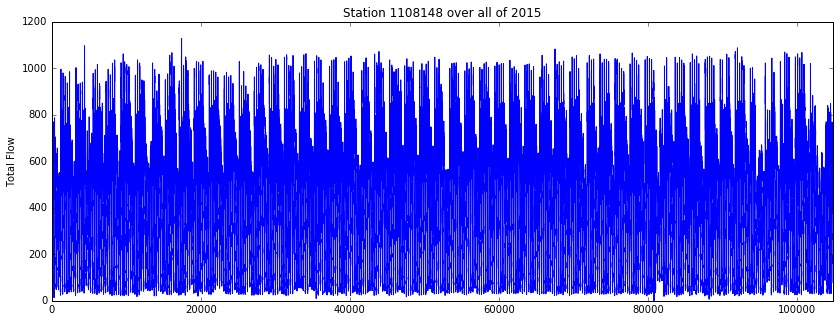

In [4]:
plt.figure(figsize=(14,5))
df['TotalFlow'].plot()
plt.title('Station 1108148 over all of 2015')
plt.ylabel('Total Flow')
plt.show()

Plot is very noisy.  Lets look at one week.

### Plot Flow for station 1108148 over a normal (no holidays) week, starting on Monday

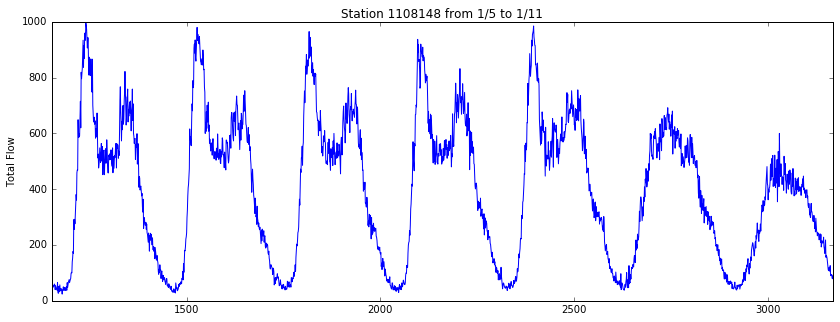

In [5]:
plt.figure(figsize=(14,5))
idx1 = df['Timestamp'] > '2015-01-05'
idx2 = df['Timestamp'] < '2015-01-12'
df.ix[(idx1 & idx2),'TotalFlow'].plot()
plt.title('Station 1108148 from 1/5 to 1/11')
plt.ylabel('Total Flow')
plt.show()

Weekly plot clearly shows diff between weekday and weekend

### Apply a FFT on the data

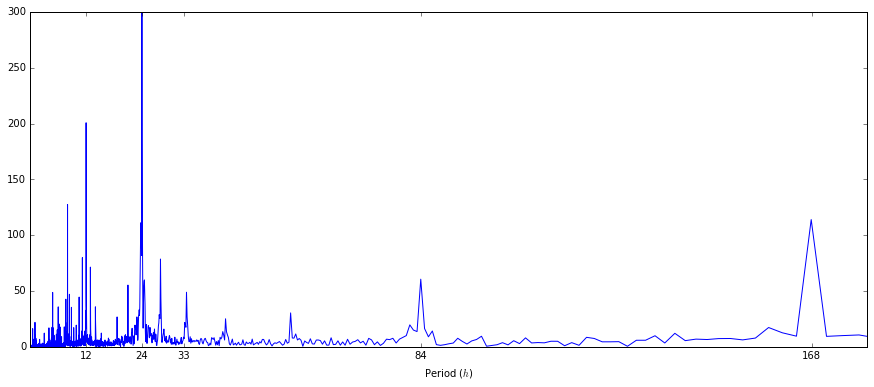

In [6]:
Y = np.fft.fft(df.TotalFlow.values)
N = len(Y)/2+1
fa = 1.0/(5.0*60.0) # every 5 minutes
X = np.linspace(0, fa/2, N, endpoint=True)
Xp = 1.0/X # in seconds
Xph= Xp/(60.0*60.0) # in hours
plt.figure(figsize=(15,6))
plt.plot(Xph, 2.0*np.abs(Y[:N])/N)
plt.xticks([12, 24, 33, 84, 168])
plt.xlim(0, 180)
plt.ylim(0, 300)
plt.xlabel('Period ($h$)')
plt.show()

FFT denisity results plot shows high correlation at the expected outcomes: 12, 24 and 168 hours.  84 is strange...

In [7]:
fft_df = pd.DataFrame({'hours':Xph, 'coef':2.0*np.abs(Y[:N])/N}).sort_values('coef', ascending=False)
fft_df.head(10)

,coef,hours
0,1739.229659,inf
364,476.109320,23.989927
728,200.747395,11.994963
363,188.585703,24.056015
1091,127.528180,8.003972
52,114.007887,167.929487
367,111.247807,23.793824
727,108.398759,12.011463
368,103.928917,23.729167
366,102.729654,23.858834


Top Coefficients are 24 hours, 12 hours, 8 hours, 168 hours (one week).  Results are difficult to parse because of decimals, so let us round the hours to the nearest integer and re-examine.

In [8]:
fft_df['nearest_hour']=fft_df['hours'].apply(lambda x: round(x,0))

#### Should we aggregate using sum or mean?  We believe that aggregating on the mean makes the most sense.  However, both show intereting results.  Also not sure how to interpret the infinity values.

In [9]:
# aggregate using sum
fft_df[['nearest_hour','coef']].groupby('nearest_hour').sum().reset_index().sort_values('coef', ascending=False)[:10]

,nearest_hour,coef
0,0.000000,10694.398844
1,1.000000,4849.623221
187,inf,1739.229659
24,24.000000,1547.087733
2,2.000000,1228.071271
8,8.000000,1220.304236
12,12.000000,956.511558
5,5.000000,734.794895
3,3.000000,693.474478
6,6.000000,611.362742


1. 0 hours = very high dependency on the immediately close values.  
2. 1 hour = still high dependency on near values (wiggles?)
3. 24 hours = one day pattern repeats
4. 2 = still high dependency on near values
5. 8 hours = general work day is 8 hours, and it divides 24 evenly, so this pattern makes inuitive sense
6. 12 hours = longer work days and divides 24 evenly?

**These results are interesting.  They validate that Cohort One's decision to perform PCA on a daily cadence was a smart choice.**

In [10]:
# aggregate using mean
fft_df[['nearest_hour','coef']].groupby('nearest_hour').mean().reset_index().sort_values('coef', ascending=False)[:10]

,nearest_hour,coef
187,inf,1739.229659
135,168.000000,114.007887
24,24.000000,103.139182
84,84.000000,60.579887
186,8732.000000,35.669727
28,28.000000,25.602442
25,25.000000,20.490816
23,23.000000,19.375384
34,34.000000,17.367500
82,82.000000,17.327968


1. 168 hours = one week
2. 24 hours = one day
3. 84 hours = half week?
4. 8732 = 363 days, 20 hours
5. 28 hours = ??
6. 25 hours = Daylight savings time full day?
7. 23 hours = Daylight savings time full day?

**These results also validate that a week or a day are the most prominent signals in the data.**

## Wavelets on Traffic Data

From video... https://www.youtube.com/watch?v=QX1-xGVFqmw <br>
Fourier transform does not capture abrupt changes in data efficiently.  <br>
Fourier uses sine waves over long periods of time <br>
Wavelets have mean zero and occur at a localized, finite, duration. <br>
Here are some examples: <br>
<img src='wavelet_examples.png' width="800">
Important concepts: <br>
Scaling: stretching or shrinking the wavelet in time <br>
Shifting: moving the wavelet along the length of the signal <br>


In [11]:
df = pd.read_csv('2015_station_days_with_meta.csv', usecols=range(1,20))
df = df.ix[df['Partition'] == 'Weekdays']
flow_df = df.pivot(index='Station', columns='Time', values='Flow')

/Users/cjstev/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


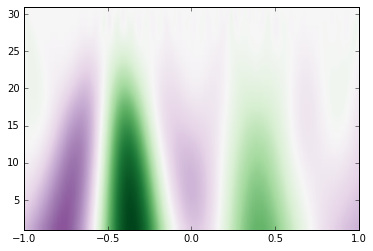

In [12]:
a = flow_df[flow_df.index==1108148]
a = np.array(a.transpose())
a = np.concatenate(a)
widths = np.arange(1, 31, 1)
cwtmatr = signal.cwt(a, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

Continuous wavelet transform shows magnitude of transform with denser colors.  Green is positive, purple is negative.  

### A Short Wavelet Scale

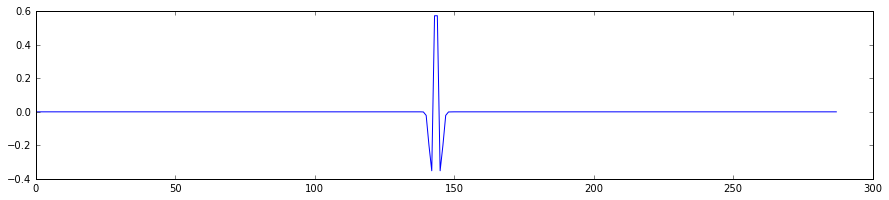

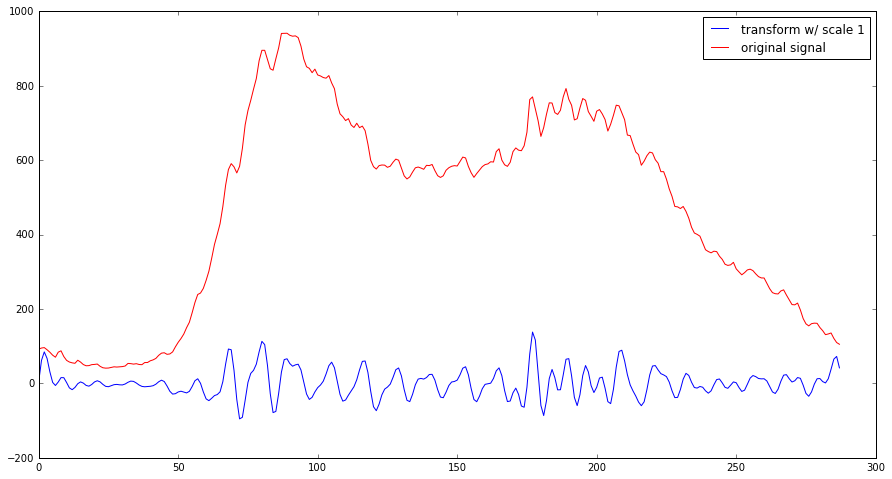

In [13]:
width = 1
plt.figure(figsize=(15,3))
plt.plot(signal.ricker(288,width))
plt.show()
plt.figure(figsize=(15,8))
plt.plot(cwtmatr[width], color='b', label = 'transform w/ scale {}'.format(str(width)))
plt.plot(a, color='r', label = 'original signal')
plt.legend()
plt.show()

Using a small scale wavelet, the wiggles are localized and exposed for a given station.

### A Larger Wavelet Scale

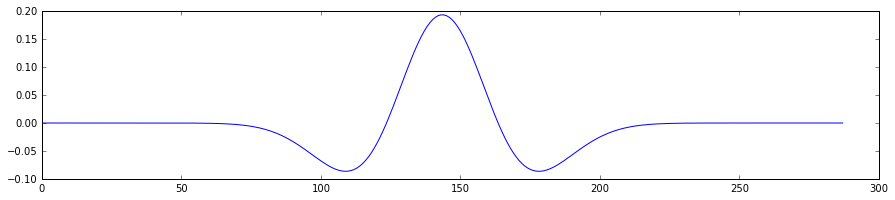

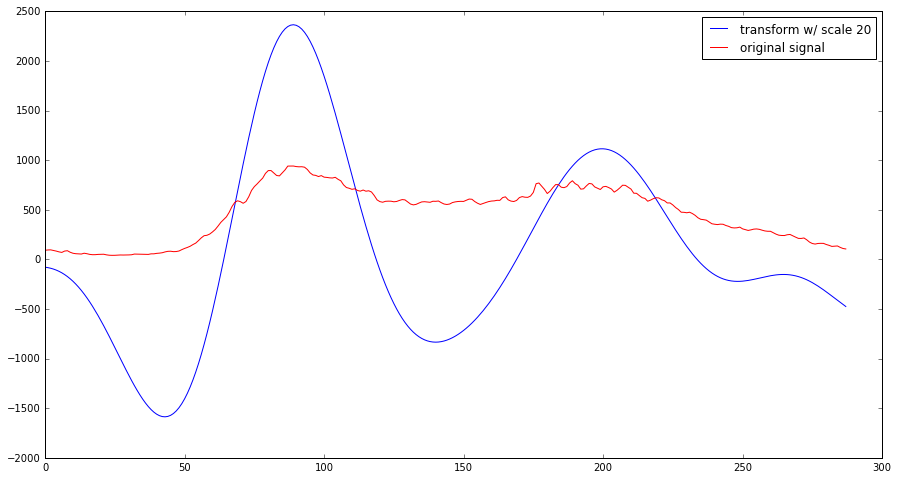

In [14]:
width = 20
plt.figure(figsize=(15,3))
plt.plot(signal.ricker(288,width))
plt.show()
plt.figure(figsize=(15,8))
plt.plot(cwtmatr[width], color='b', label = 'transform w/ scale {}'.format(str(width)))
plt.plot(a, color='r', label = 'original signal')
plt.legend()
plt.show()

Alternatively, if we use a large scale wavelet, the general pattern in the data is exagerated.  

### Many Wavelet Scales

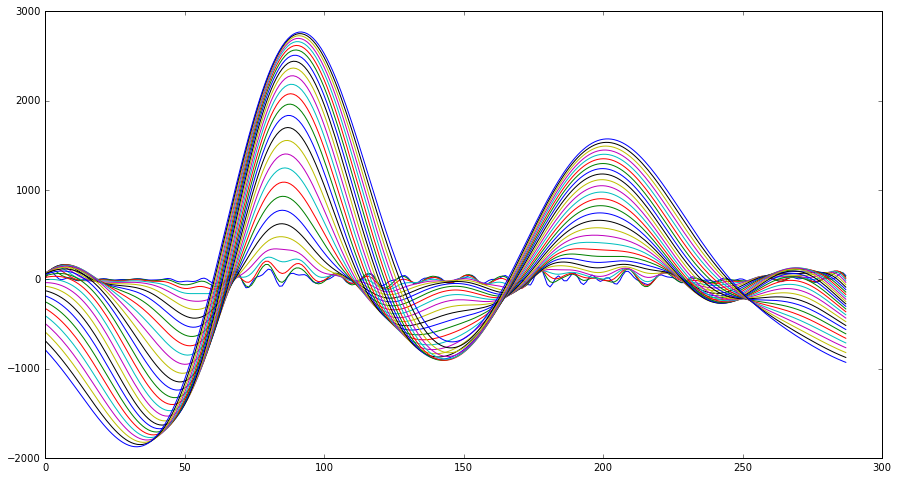

In [15]:
plt.figure(figsize=(15,8))
for width in range(1,30):
    plt.plot(cwtmatr[width], label = 'transform w/ scale {}'.format(str(width)))
plt.show()

This plot is equivalent to the pruple/green plot above.  Just shown as a cross section instead of a heatmap.